In [1]:
# データ準備
import numpy as npy
import matplotlib.pyplot as plt
%matplotlib inline
# 生データファイルから取り出す
sample_data = npy.load('neural_rawdata.npz')
# 入力値の設定
X=sample_data['X']
# がく片の長さの表示範囲設定
X_range0=sample_data['X_range0']
# がく片の幅の表示範囲設定
X_range1=sample_data['X_range1']
# クラス（答え）の設定
T3=sample_data['T3']

# データの並び替え
X1 = X[:50,:]
X2 = X[50:100,:]
X3 = X[100:150,:]

npy.random.shuffle(X1)
npy.random.shuffle(X2)
npy.random.shuffle(X3)

X_test=npy.r_[X1[:25,:], X2[:25,:], X3[:25,:]]
X_train=npy.r_[X1[25:50,:],X2[25:50,:],X3[25:50,:]]
T_test=npy.r_[T3[:25,:], T3[50:75,:], T3[100:125,:]]
T_train=npy.r_[T3[25:50,:],T3[75:100,:],T3[125:150,:]]

npy.savez('neural_data.npz',X_train=X_train, T_train=T_train,X_test=X_test,T_test=T_test,X_range0=X_range0,X_range1=X_range1)


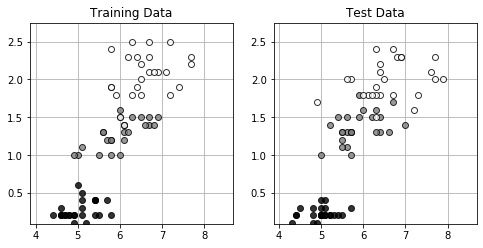

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# データの表示
def Show_data(x,t):
    wk,n=t.shape
    c=[[0,0,0],[.5,.5,.5],[1,1,1]]
    for i in range(n):
        plt.plot(x[t[:,i]==1,0],x[t[:,i]==1,1],linestyle='none',marker='o',markeredgecolor='black',color=c[i],alpha=0.8)
    plt.grid(True)

plt.figure(1,figsize=(8,3.7))
plt.subplot(1,2,1)
Show_data(X_train,T_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Training Data')
plt.subplot(1,2,2)
Show_data(X_test,T_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Test Data')

plt.show()


In [3]:
# シグモイド関数
def Sigmoid(x):
    y=1/(1+npy.exp(-x))
    return y

# ニューラルネットワーク（wv重み、M中間層ノード数、K出力層ノード数、x入力層の入力値）
def FNN(wv, M, K, x):
    # Nデータ数　Dデータの入力次元
    N, D = x.shape
    # w 入力層⇒中間層の重み
    w = wv[:M * (D+1)]
    w = w.reshape(M,(D+1))
    # v 中間層⇒出力層の重み
    v = wv[M*(D+1):]
    v = v.reshape((K,M+1))
    # b 中間層の入力総和
    b = npy.zeros((N,M+1))
    # z 中間層の出力値
    z = npy.zeros((N,M+1))
    # a 出力層の入力総和
    a = npy.zeros((N,K))
    # y 出力層の出力値
    y = npy.zeros((N,K))
    
    # データごとに中間層、出力層の計算を行う
    for n in range(N):
        # 中間層の計算（シグモイド関数）
        for m in range(M):
            b[n,m] = npy.dot(w[m,:],npy.r_[x[n,:],1])
            z[n,m] = Sigmoid(b[n,m])
        # ダミーニューロン
        z[n,M]=1
        u=0
        # 出力層の計算（）
        for k in range(K):
            a[n,k] = npy.dot(v[k,:],z[n,:])
            u = u + npy.exp(a[n,k])
        for k in range(K):
            y[n,k] = npy.exp(a[n,k])/u
    return y,a,z,b

# 平均誤差エントロピー誤差
def CE_FNN(wv,M,K,x,t):
    N,D = x.shape
    y,a,z,b=FNN(wv,M,K,x)
    ce = -npy.dot(t.reshape(-1),npy.log(y.reshape(-1))) / N
    return ce


In [4]:
# 解析的微分
def dCE_FNN(wv,M,K,x,t):
    N,D = x.shape
    w = wv[:M*(D+1)]
    w = w.reshape(M,(D+1))
    v = wv[M*(D+1):]
    v = v.reshape((K,M+1))
    # xを入力してyを得る
    y,a,z,b = FNN(wv,M,K,x)
    dwv = npy.zeros_like(wv)
    dw = npy.zeros((M,D+1))
    dv = npy.zeros((K,M+1))
    # 中間層の誤差
    delta1 = npy.zeros(M)
    # 出力層の誤差
    delta2 = npy.zeros(K)

    # データの数だけループさせる
    for n in range(N):
        # dv 出力層のニューロン数だけループ
        for k in range(K):
            # 出力層の誤差
            delta2[k] = (y[n,k]-t[n,k])
            # vの勾配dvを求める(平均値)
            dv[k,:] = dv[k,:] + delta2[k]*z[n,:]/N
        # dw　中間層のニューロンの数だけループ
        for j in range(M):
            # 中間層の誤差
            delta1[j] = z[n,j]*(1-z[n,j])*npy.dot(v[:,j],delta2)
            # wの勾配dwを求める（平均値）
            dw[j,:] = dw[j,:] + delta1[j]*npy.r_[x[n,:],1]/N

    # dwvを生成
    dwv = npy.c_[dw.reshape((1,M*(D+1))), dv.reshape((1,K*(M+1)))]
    dwv = dwv.reshape(-1)
    return dwv


In [5]:
# 勾配法による最適パラメータの導出
def Fit_FNN(wv_init,M,K,x_train,t_train,x_test,t_test,n,alpha):
    wv = wv_init.copy()
    err_train =npy.zeros(n)
    err_test = npy.zeros(n)
    wv_hist = npy.zeros((n,len(wv_init)))
    for i in range(n):
        wv = wv -alpha*dCE_FNN(wv,M,K,x_train,t_train)
        err_train[i] = CE_FNN(wv,M,K,x_train,t_train)
        err_test[i] = CE_FNN(wv,M,K,x_test,t_test)
        wv_hist[i,:]=wv
    return wv, wv_hist, err_train, err_test

In [16]:
import time
# 勾配法による最適パラメータの導出
def Fit_FNN(wv_init,M,K,x_train,t_train,x_test,t_test,n,alpha):
    wv = wv_init.copy()
    err_train =npy.zeros(n)
    err_test = npy.zeros(n)
    wv_hist = npy.zeros((n,len(wv_init)))
    for i in range(n):
        wv = wv -alpha*dCE_FNN(wv,M,K,x_train,t_train)
        err_train[i] = CE_FNN(wv,M,K,x_train,t_train)
        err_test[i] = CE_FNN(wv,M,K,x_test,t_test)
        wv_hist[i,:]=wv
    return wv, wv_hist, err_train, err_test

startTime = time.time()
M = 2
K = 3

npy.random.seed(1)
WV_init = npy.random.normal(0,0.01,M*3+K*(M+1))
N_step=1000
alpha=0.215
WV,WV_hist,Err_train,Err_test=Fit_FNN(WV_init,M,K,X_train,T_train,X_test,T_test,N_step,alpha)
calculation_time = time.time()-startTime
print("Claculation time:{0:.3f}sec".format(calculation_time))


Claculation time:36.184sec


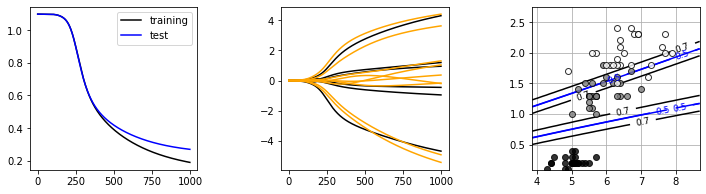

In [6]:
# 境界線の表示
def show_FNN(wv,M,K):
    xn = 60
    x0 = npy.linspace(X_range0[0],X_range0[1],xn)
    x1 = npy.linspace(X_range1[0],X_range1[1],xn)
    xx0, xx1 = npy.meshgrid(x0,x1)
    x = npy.c_[npy.reshape(xx0,xn*xn,1),npy.reshape(xx1,xn*xn,1)]
    y,a,z,b = FNN(wv,M,K,x)
    plt.figure(1,figsize=(4,4))
    for ic in range(K):
        f = y[:,ic]
        f = f.reshape(xn,xn)
        f = f.T
        cont = plt.contour(xx0,xx1,f,levels=[0.5,0.7],colors=['blue','black'])
        cont.clabel(fmt='%.1f',fontsize=9)
        plt.xlim(X_range0)
        plt.ylim(X_range1)

# 勾配法のステップ数
N_step=1000
# 更新規則の学習率
alpha=0.215

M = 2
K = 3
# 重みの初期値設定
npy.random.seed(1)
WV_init = npy.random.normal(0,0.01,M*3+K*(M+1))
# 勾配法
WV,WV_hist,Err_train,Err_test=Fit_FNN(WV_init,M,K,X_train,T_train,X_test,T_test,N_step,alpha)

# グラフの表示
plt.figure(1,figsize=(12,3))
plt.subplots_adjust(wspace=0.5)

# 学習誤差の遷移表示
plt.subplot(1,3,1)
plt.plot(Err_train, 'black',label='training')
plt.plot(Err_test, 'blue', label='test')
plt.legend()

# 重みの時間遷移を表示
plt.subplot(1,3,2)
plt.plot(WV_hist[:,:M*3],'black')
plt.plot(WV_hist[:,M*3:],'orange')

# 境界線の表示
plt.subplot(1,3,3)
Show_data(X_test,T_test)
M = 2
K = 3
show_FNN(WV,M,K)
plt.show()